# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
%%script false --no-raise-error
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import math

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [2]:
%%script false --no-raise-error

# Standard transformation for MNIST dataset.
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load MNIST train and test datasets.
mnist_train_full = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=mnist_transform)

# Create validation set from training data.
validation_size = 5000
permuted_indices = np.random.permutation(len(mnist_train_full))
mnist_validation = Subset(mnist_train_full, permuted_indices[:validation_size])
mnist_train = Subset(mnist_train_full, permuted_indices[validation_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [3]:
%%script false --no-raise-error

from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Train the model for one epoch using the provided data loader.
def train_one_epoch(model, dataloader, optimizer, epoch_label='Unknown', device='cpu'):
    model.train()
    epoch_losses = []
    for inputs, targets in tqdm(dataloader, desc=f'Training epoch {epoch_label}', leave=True):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    return np.mean(epoch_losses)

# Evaluate the model on the entire dataset provided by the data loader.
def evaluate_model_performance(model, dataloader, device='cpu'):
    model.eval()
    all_predictions = []
    all_targets = []

    for inputs, targets in tqdm(dataloader, desc='Evaluating', leave=False):
        inputs = inputs.to(device)
        logits = model(inputs)
        preds = torch.argmax(logits, dim=1)

        all_targets.append(targets)
        all_predictions.append(preds.detach().cpu().numpy())
        
    targets_flat = np.hstack(all_targets)
    predictions_flat = np.hstack(all_predictions)

    return (
        accuracy_score(targets_flat, predictions_flat),
        classification_report(targets_flat, predictions_flat, zero_division=0, digits=3)
    )

# Plot training loss and validation accuracy across epochs.
def plot_training_curves(metrics_per_epoch):
    training_losses = [loss for (loss, _) in metrics_per_epoch]
    validation_accuracies = [acc for (_, acc) in metrics_per_epoch]

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(training_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(validation_accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    best_epoch = np.argmax(validation_accuracies)
    best_accuracy = np.max(validation_accuracies)
    plt.title(f'Best Accuracy = {best_accuracy} @ epoch {best_epoch}')


#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [4]:
%%script false --no-raise-error

class FeedForwardMLP(nn.Module):
    def __init__(self, layer_dims):
        super().__init__()
        self.linear_layers = nn.ModuleList([
            nn.Linear(in_features, out_features) 
            for in_features, out_features in zip(layer_dims[:-1], layer_dims[1:])
        ])
    
    def forward(self, x):
        # Apply a sequence of Linear + ReLU (except last) in a functional style
        return reduce(
            lambda composed, layer: lambda x: layer(F.relu(composed(x))),
            self.linear_layers,
            lambda x: x.flatten(1)
        )(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

In [5]:
%%script false --no-raise-error

# Device and training hyperparameters.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

num_epochs = 30
learning_rate = 0.01
batch_size = 512

# Model architecture parameters.
input_dim = 28 * 28
# hidden_width = 16
# hidden_depth = 2

# Data loaders.
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, num_workers=4)
test_loader  = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=True, num_workers=4)

# Model and optimizer setup.
mlp_model = FeedForwardMLP([input_dim, 256, 128, 10]).to(device)  # or: [hidden_width] * hidden_depth + [10]
optimizer = torch.optim.Adam(params=mlp_model.parameters(), lr=learning_rate)

# Training loop.
training_metrics = []
for current_epoch in range(num_epochs):
    epoch_loss = train_one_epoch(mlp_model, train_loader, optimizer, current_epoch, device=device)
    val_accuracy, _ = evaluate_model_performance(mlp_model, val_loader, device=device)
    training_metrics.append((epoch_loss, val_accuracy))

# Plot performance curves.
plot_training_curves(training_metrics)

# Final evaluation on test set.
_, test_report = evaluate_model_performance(mlp_model, test_loader, device=device)
print(f'Accuracy report on TEST:\n{test_report}')


### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [6]:
#some necessary imports for the entire notebook to run


import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split, Subset
import torchvision
from torchvision import transforms
from torchvision.models.resnet import BasicBlock, Bottleneck

from tqdm.auto import tqdm
import inspect
import numpy as np
import math
import random

/home/marco/miniforge3/envs/DLA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Set random seeds for reproducibility.
# Note: This is not a guarantee of reproducibility across different hardware or software versions.

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True

In [8]:
# Directory paths for dataset, model checkpoints, and logs.
DATA_DIR = './data'
CHECKPOINTS_DIR = './checkpoints'
LOGS_DIR = './logs'

# Training hyperparameters.
BATCH_SIZE = 128
NUM_WORKERS = 4
LEARNING_RATE = 1e-3
EARLY_STOPPING_PATIENCE = 3
NUM_EPOCHS = 30

# Device setup.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [9]:
#TensorBoard setup. #This is your window to visualize tensorboard logs.
%load_ext tensorboard
%tensorboard --logdir=./logs

In [10]:
import os
import shutil

def clear_directory(directory_path):
    """
    Deletes the contents of the given directory if it exists,
    then recreates an empty directory at the same path.
    """
    if os.path.exists(directory_path):
        if os.path.isdir(directory_path):
            shutil.rmtree(directory_path)
    os.makedirs(directory_path, exist_ok=True)

# Example usage to clear directories before starting training:
# clear_directory(DATA_DIR)
# clear_directory(CHECKPOINTS_DIR)
# clear_directory(LOGS_DIR)


In [11]:
# Import personal modules for training pipeline and model architectures.
from SLTrainingPipeline import SLTrainingPipeline
from MLP import MLP, ResMLP
from CNN import CNN, ResCNN


In [12]:
# Callbacks for monitoring training dynamics and metrics.

def log_gradient_magnitudes(pipeline, **context):
    """
    Logs gradient magnitudes of first and last layers, plus their ratio,
    at regular intervals during training.
    """
    if not context.get("is_training", False) or not pipeline.writer:
        return

    log_interval = 32
    writer = pipeline.writer
    model = pipeline.model
    run_id = pipeline.run_id
    batch_size = context.get("batch_size", 64)
    global_step = pipeline.current_epoch * batch_size + pipeline.current_batch

    if global_step % log_interval != 0:
        return

    grad_params = [
        (idx, name, param)
        for idx, (name, param) in enumerate(model.named_parameters())
        if param.requires_grad and param.grad is not None and "bias" not in name
    ]

    if not grad_params:
        return

    first_idx, first_name, first_param = grad_params[0]
    last_idx, last_name, last_param = grad_params[-1]

    first_grad_norm = torch.norm(first_param.grad).item()
    last_grad_norm = torch.norm(last_param.grad).item()

    writer.add_scalar(f"grad_first_layer/{run_id}", first_grad_norm, global_step)
    writer.add_scalar(f"grad_last_layer/{run_id}", last_grad_norm, global_step)

    if first_grad_norm > 0:
        grad_ratio = last_grad_norm / first_grad_norm
        writer.add_scalar(f"grad_last_to_first_ratio/{run_id}", grad_ratio, global_step)

    writer.flush()


def monitor_initial_weight_change(pipeline, **context):
    """
    At the start of training, stores initial weights mean values,
    then after the first epoch prints how much weights changed.
    """
    if not context.get('is_training', False) or pipeline.current_batch != 0:
        return

    epoch = pipeline.current_epoch

    if epoch == 0:
        pipeline.callbacks_data['initial_weights'] = {
            name: param.data.clone().mean().item()
            for name, param in pipeline.model.named_parameters()
        }
    elif epoch == 1:
        print("Weight changes after first epoch:")
        for name, param in pipeline.model.named_parameters():
            initial_mean = pipeline.callbacks_data['initial_weights'][name]
            current_mean = param.data.mean().item()
            change = abs(current_mean - initial_mean)
            print(f"{name}: initial = {initial_mean:.6f}, current = {current_mean:.6f}, change = {change:.6f}")


# Dictionary registering callbacks by training event hooks.
gradient_callbacks = {
    # 'on_batch_begin': [monitor_initial_weight_change],
    'on_after_back': [log_gradient_magnitudes]
}


# Metrics definitions.

def accuracy_metric(logits, targets):
    _, predicted_labels = torch.max(logits.data, dim=1)
    return (predicted_labels == targets).float().mean().item()

metrics = {"accuracy": accuracy_metric}


In [13]:
# MNIST dataset loading and preprocessing with train/validation split.

# Define the standard MNIST transforms: to tensor and normalize.
mnist_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Train/validation split ratio.
train_ratio = 0.8
val_ratio = 0.2

# Load full training dataset (train=True) and test dataset (train=False).
full_train_dataset = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=mnist_transforms)
test_dataset = torchvision.datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=mnist_transforms)

# Compute sizes for train and validation splits.
train_size = int(train_ratio * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split dataset into train and validation subsets.
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders with shuffling for train and val, and also for test.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:32<00:00,  1.08s/it]

training time: 32.52



/home/marco/Desktop/University/DLA/Labs (1,2,3)/BaseTrainingPipeline.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(file_path, map_location = sel

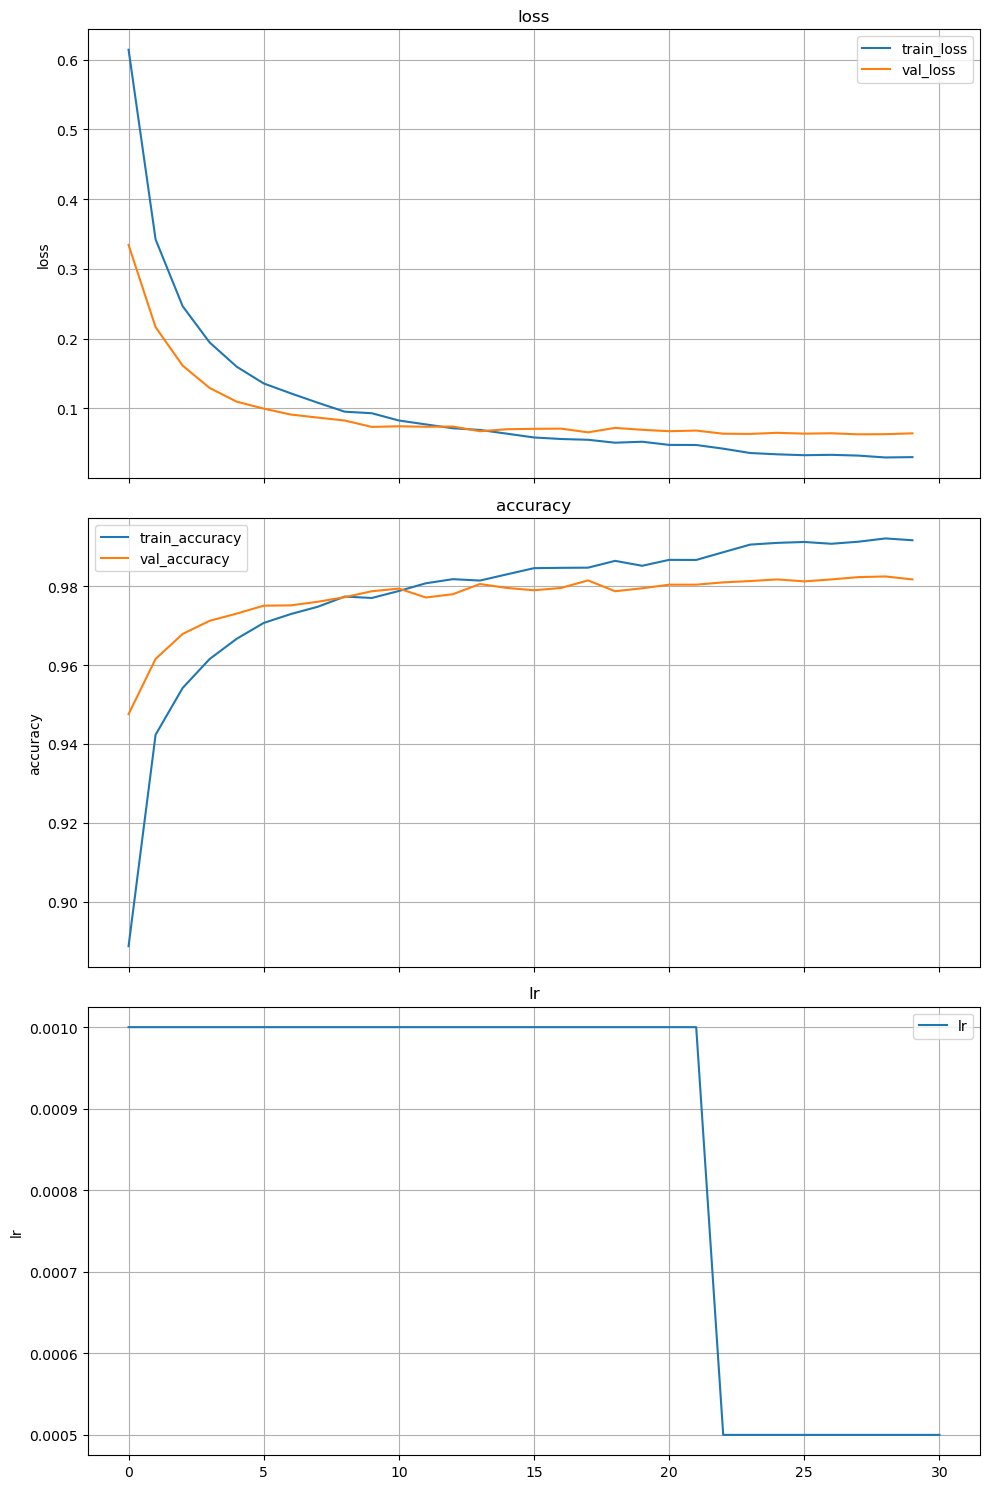

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}, ylabel='loss'>,
        <Axes: title={'center': 'accuracy'}, ylabel='accuracy'>,
        <Axes: title={'center': 'lr'}, ylabel='lr'>], dtype=object))

In [14]:
# Define and train a simple MLP model on MNIST dataset.

# Instantiate the MLP with 3 hidden layers, ReLU activations, batch norm, and dropout.
mlp_model = MLP(
    layer_sizes=[28*28, 128, 64, 10],
    act_funcs=[nn.ReLU, nn.ReLU, None],
    use_batch_norm=True,
    dropouts=[0.2, 0.2, 0.0]
)

# Set optimizer and learning rate scheduler.
optimizer = optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=EARLY_STOPPING_PATIENCE
)

# Initialize the training pipeline.
training_pipeline = SLTrainingPipeline(
    model=mlp_model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    metrics=metrics,
    device=device,
    run_id='test_mlp_class',
    checkpoint_dir=CHECKPOINTS_DIR,
    log_dir=LOGS_DIR,
    callbacks=gradient_callbacks
)

# Run the training.
training_history = training_pipeline.fit(
    epochs=NUM_EPOCHS,
    train_loader=train_loader,
    val_loader=val_loader,
    verbose=False
)

# Load the best model checkpoint.
training_pipeline.load()

# Plot training metrics (loss, accuracy, etc.).
training_pipeline.plot()


### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [15]:
# Depth competition: comparing standard MLP and ResMLP with varying depths on MNIST.
# ResMLP uses skip connections to alleviate vanishing gradients in deeper nets.

depth_values = [4, 8, 16, 32]
hidden_dim = 32
input_dim = 28 * 28
output_dim = 10

for depth in depth_values:
    # Define layer sizes: input, hidden repeated (depth-1) times, output.
    layers = [input_dim] + [hidden_dim] * (depth - 1) + [output_dim]
    # Activation functions: sigmoid for all but last (which has no activation).
    activations = [nn.Sigmoid] * (depth - 2)
    init_function = nn.init.xavier_uniform_  # Xavier init to highlight vanishing gradients.

    # Instantiate standard MLP.
    mlp_model = MLP(
        layer_sizes=layers,
        act_funcs=activations,
        init_funcs=init_function
    )

    optimizer = optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=EARLY_STOPPING_PATIENCE
    )

    mlp_pipeline = SLTrainingPipeline(
        model=mlp_model,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler,
        metrics=metrics,
        device=device,
        run_id=f'mlp_gradient_depth_{depth}',
        log_dir=LOGS_DIR,
        callbacks=gradient_callbacks
    )

    mlp_pipeline.fit(
        epochs=NUM_EPOCHS,
        train_loader=train_loader,
        val_loader=val_loader,
        verbose=False
    )

    mlp_results = mlp_pipeline.evaluate(test_loader, verbose=True)

    # Instantiate ResMLP with skip connection from layer 1 to layer (depth-2).
    resmlp_model = ResMLP(
        layer_sizes=layers,
        act_funcs=activations,
        init_funcs=init_function,
        skip_connections=[(1, depth - 2)]
    )

    optimizer = optim.Adam(resmlp_model.parameters(), lr=LEARNING_RATE)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=EARLY_STOPPING_PATIENCE
    )

    resmlp_pipeline = SLTrainingPipeline(
        model=resmlp_model,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler,
        metrics=metrics,
        device=device,
        run_id=f'resmlp_gradient_depth_{depth}',
        log_dir=LOGS_DIR,
        callbacks=gradient_callbacks
    )

    resmlp_pipeline.fit(
        epochs=NUM_EPOCHS,
        train_loader=train_loader,
        val_loader=val_loader,
        verbose=False
    )

    resmlp_results = resmlp_pipeline.evaluate(test_loader, verbose=True)


100%|██████████| 30/30 [00:31<00:00,  1.06s/it]


training time: 31.81


test_loss: 0.1642
test_accuracy: 0.9554


100%|██████████| 30/30 [00:31<00:00,  1.06s/it]


training time: 31.77


test_loss: 0.1380
test_accuracy: 0.9604


100%|██████████| 30/30 [00:42<00:00,  1.40s/it]


training time: 42.05


test_loss: 0.6420
test_accuracy: 0.8308


100%|██████████| 30/30 [00:42<00:00,  1.42s/it]


training time: 42.70


test_loss: 0.1577
test_accuracy: 0.9555


100%|██████████| 30/30 [01:03<00:00,  2.11s/it]


training time: 63.27


test_loss: 1.0298
test_accuracy: 0.6269


100%|██████████| 30/30 [01:03<00:00,  2.12s/it]


training time: 63.68


test_loss: 0.1441
test_accuracy: 0.9550


100%|██████████| 30/30 [01:42<00:00,  3.40s/it]


training time: 102.15


test_loss: 2.3010
test_accuracy: 0.1135


100%|██████████| 30/30 [01:43<00:00,  3.45s/it]


training time: 103.44


test_loss: 0.1368
test_accuracy: 0.9599


### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [ ]:
# CIFAR10 dataset loading and preprocessing with augmentation

cifar_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

split_ratio = [0.8, 0.2]  # train/val split

cifar_train_val_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=cifar_transform)
cifar_test_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=cifar_transform)

train_len = int(split_ratio[0] / sum(split_ratio) * len(cifar_train_val_dataset))
val_len = len(cifar_train_val_dataset) - train_len

cifar_train_dataset, cifar_val_dataset = torch.utils.data.random_split(cifar_train_val_dataset, [train_len, val_len])

train_loader = DataLoader(cifar_train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)  # shuffle=False per es. 2.2
val_loader = DataLoader(cifar_val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(cifar_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


Files already downloaded and verified
Files already downloaded and verified


In [17]:
import math
import torch.optim as optim
import torch.nn as nn

input_shape = (3, 32, 32)
output_size = 10

depths = [6, 12, 20]  # Number of convolutional layers
max_pool_layers = int(math.log(min(input_shape[1], input_shape[2]), 2) - 2)  # Number of max pooling layers
chan_per_block = [64, 128, 256, 512]

def build_mlp_tail(cnn_output_size, output_size=10, hidden_dim=512):
    return MLP(
        layer_sizes=[cnn_output_size, hidden_dim, output_size],
        act_funcs=[nn.ReLU, None],  # ReLU should suffer less from vanishing gradients
        dropouts=[0.5, 0.0],
        use_bias=True
    )

for i, d in enumerate(depths):
    architecture = []

    for block in range(max_pool_layers):
        # Distribute conv layers evenly among blocks
        num_conv = d // max_pool_layers if block != max_pool_layers - 1 else d - (max_pool_layers - 1) * (d // max_pool_layers)
        out_chan = chan_per_block[block]

        for conv in range(num_conv):
            layer_config = {
                "out_channels": out_chan,
                "kernel": 3,
                "stride": 1,
                "padding": 1,
                "use_batch_norm": True,
                "act_func": nn.ReLU
            }

            if conv == num_conv - 1:
                layer_config["pool"] = nn.MaxPool2d
                layer_config["pool_kernel"] = 2
                layer_config["pool_stride"] = 2
                layer_config["pool_padding"] = 0

            architecture.append(layer_config)

    # Standard CNN
    cnn = CNN(input_shape, architecture)
    cnn_output_size = cnn.get_output_size()

    mlp_tail_cnn = build_mlp_tail(cnn_output_size, output_size=output_size)
    cnn.attach_mlp(mlp_tail_cnn)

    optimizer_cnn = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)
    scheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, mode='min', factor=0.5, patience=EARLY_STOPPING_PATIENCE)

    pipeline_cnn = SLTrainingPipeline(
        model=cnn,
        optimizer=optimizer_cnn,
        lr_scheduler=scheduler_cnn,
        metrics=metrics,
        device=device,
        run_id=f'cnn_{d}convs',
        log_dir=LOGS_DIR,
    )

    history_cnn = pipeline_cnn.fit(
        epochs=NUM_EPOCHS,
        train_loader=train_loader,
        val_loader=val_loader,
        verbose=False
    )

    # ResCNN with skip connections
    rescnn = ResCNN(input_shape, architecture)
    rescnn_output_size = rescnn.get_output_size()

    mlp_tail_rescnn = build_mlp_tail(rescnn_output_size, output_size=output_size)
    rescnn.attach_mlp(mlp_tail_rescnn)

    optimizer_rescnn = optim.Adam(rescnn.parameters(), lr=LEARNING_RATE)
    scheduler_rescnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_rescnn, mode='min', factor=0.5, patience=EARLY_STOPPING_PATIENCE)

    pipeline_rescnn = SLTrainingPipeline(
        model=rescnn,
        optimizer=optimizer_rescnn,
        lr_scheduler=scheduler_rescnn,
        metrics=metrics,
        device=device,
        run_id=f'rescnn_{d}convs',
        log_dir=LOGS_DIR,
    )

    history_rescnn = pipeline_rescnn.fit(
        epochs=NUM_EPOCHS,
        train_loader=train_loader,
        val_loader=val_loader,
        verbose=False
    )


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [01:32<00:00,  3.10s/it]


training time: 92.89


100%|██████████| 30/30 [03:12<00:00,  6.41s/it]


training time: 192.37


100%|██████████| 30/30 [02:58<00:00,  5.95s/it]


training time: 178.55


100%|██████████| 30/30 [06:12<00:00, 12.43s/it]


training time: 372.84


100%|██████████| 30/30 [04:47<00:00,  9.60s/it]


training time: 287.88


100%|██████████| 30/30 [09:57<00:00, 19.93s/it]

training time: 597.84


-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [18]:
# Your code here.

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [43]:
########## CALLBACKS TO SAVE SOFT LABELS DURING TEACHER EVALUATION ##############
#why on evaluation? we want to save logits of training set but we do not want to update
#the gradients while saving them, logits are obviously computeted at training time too
#but this way is just easier to setup with my class. We gonna pass training set at evaluation
#just to save them.


def activate_logits_saving(pipeline, **context):
    pipeline.callbacks_data["save_logits"] = True
    pipeline.callbacks_data["soft_labels"] = []


def save_logits(pipeline, **context):
    if context.get("is_training", True):
        return
        
    if not pipeline.callbacks_data.get("save_logits", False):
        return

    logits = context.get("logits")
    
    if logits is not None:
        pipeline.callbacks_data["soft_labels"].append(logits.detach().cpu())

callbacks = {
    "on_eval_begin": [activate_logits_saving],
    "on_batch_end": [save_logits]
}

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [07:38<00:00, 15.30s/it]


training time: 458.97


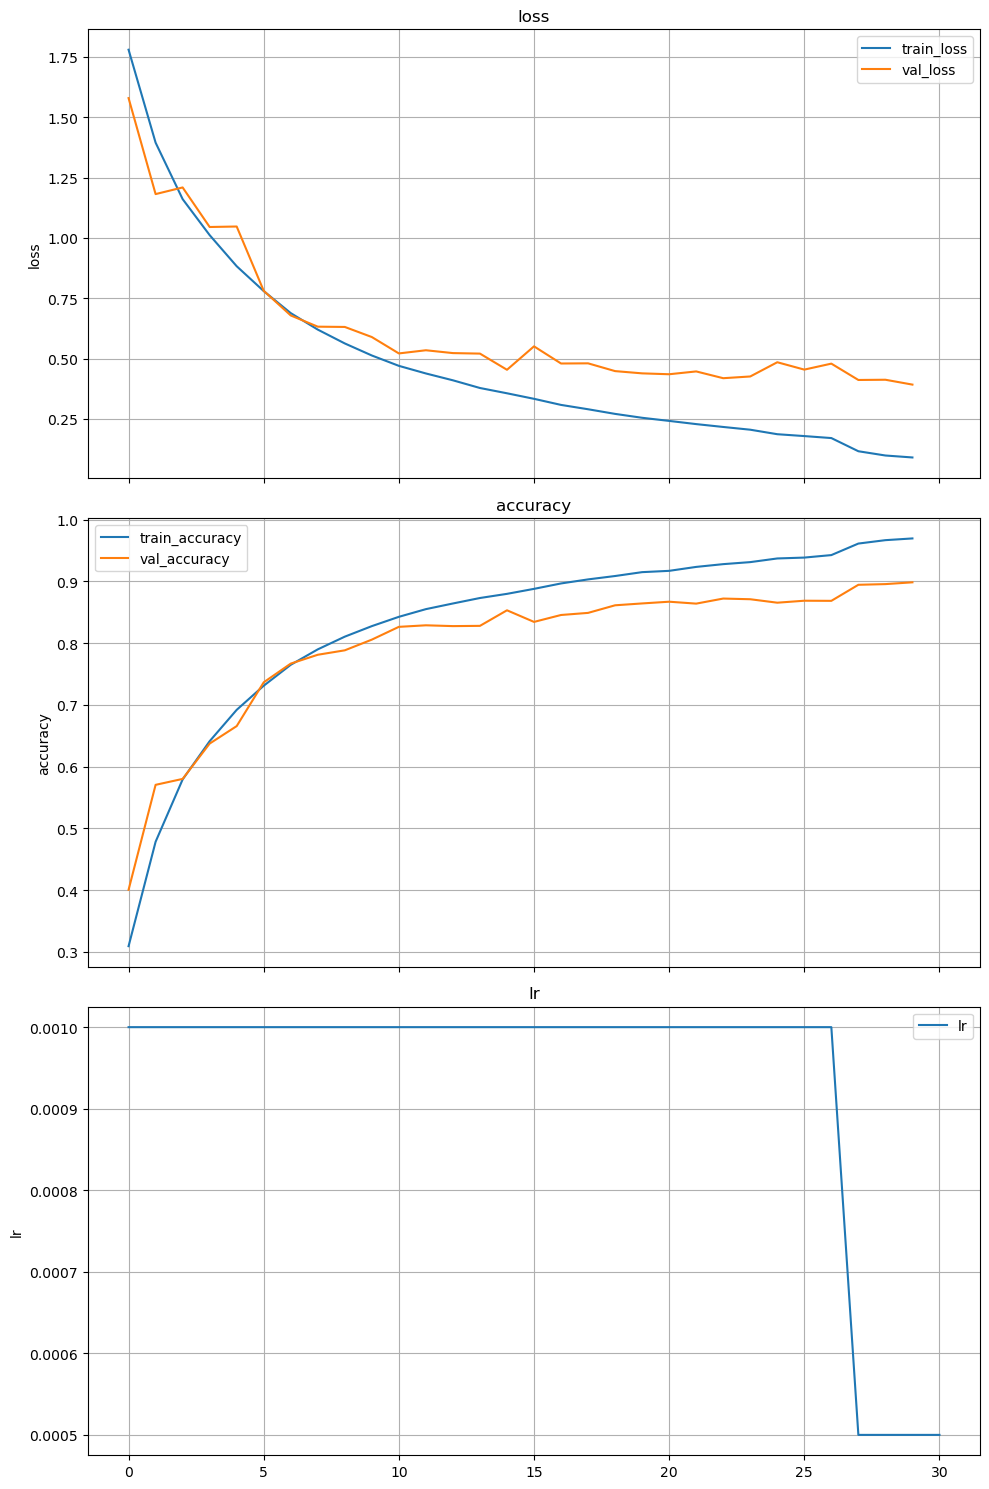

In [47]:
################ TEACHER ################ (res34)

res_layers_teacher = []
depth = 34
blocks_per_stage = [3, 4, 6, 3]
channels = [64, 128, 256, 512]
input_shape = (3, 32, 32)

for stage, (n_blocks, out_channels) in enumerate(zip(blocks_per_stage, channels)):
    for block_idx in range(n_blocks):
        stride = 2 if block_idx == 0 and stage > 0 else 1
        layer_config = {
            "out_channels": out_channels,
            "stride": stride,
            "dropout": 0.0,
            "pool": None
        }
        res_layers_teacher.append(layer_config)

teacher = ResCNN(
    input_shape = input_shape,
    res_layers = res_layers_teacher,
    block_type = BasicBlock,
    base_width = 64,
    norm_layer = nn.BatchNorm2d
)

output_size = teacher.get_output_size()
mlp_tail = MLP( #should i put softmax as act func? probably yes
    layer_sizes = [output_size, 512, 10],
    act_funcs = [nn.ReLU, None],
    dropouts = [0.5, 0.0],
    use_bias = True
)
teacher.attach_mlp(mlp_tail)

optimizer = torch.optim.Adam(teacher.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = EARLY_STOPPING_PATIENCE)

pipeline = SLTrainingPipeline(
    model = teacher,
    optimizer = optimizer,
    lr_scheduler = scheduler,
    metrics = metrics,
    device = device,
    run_id = 'teacher',
    log_dir = LOGS_DIR,
    checkpoint_dir = "." + CHECKPOINTS_DIR,
    callbacks = callbacks
)

history = pipeline.fit(epochs = NUM_EPOCHS, train_loader =train_loader, val_loader = val_loader, verbose = False)
#pipeline.load()

pipeline.plot()
#we just use evaluation to compute soft_labels thats why test_loader is train_loader
pipeline.evaluate(test_loader = train_loader, verbose = False)

soft_labels = pipeline.get_callbacks_data()["soft_labels"]

/home/marco/Desktop/University/DLA/Labs (1,2,3)/BaseTrainingPipeline.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(file_path, map_location = self

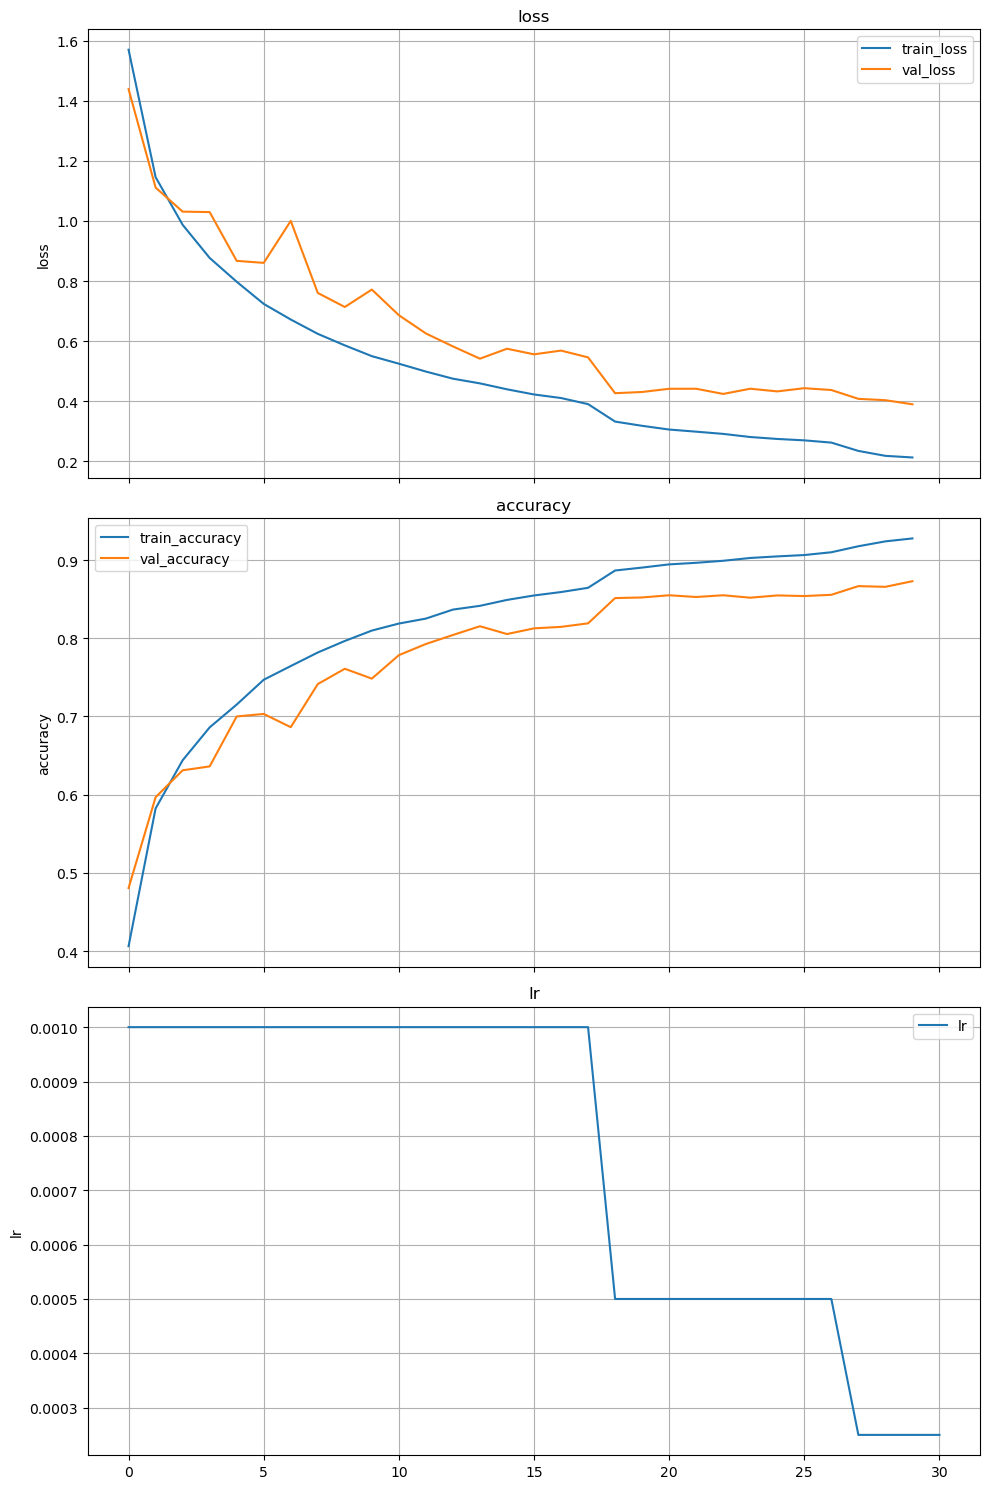

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}, ylabel='loss'>,
        <Axes: title={'center': 'accuracy'}, ylabel='accuracy'>,
        <Axes: title={'center': 'lr'}, ylabel='lr'>], dtype=object))

In [49]:
################ STUDENT ################ (res8)

res_layers_student = []
blocks_per_stage = [1, 2, 1]#2, 1]
channels = [32, 64, 128]#, 256]

for stage, (n_blocks, out_channels) in enumerate(zip(blocks_per_stage, channels)):
    for block_idx in range(n_blocks):
        stride = 2 if block_idx == 0 and stage > 0 else 1
        layer_config = {
            "out_channels": out_channels,
            "stride": stride,
            "dropout": 0.0,
            "pool": None
        }
        res_layers_student.append(layer_config)

student = ResCNN(
    input_shape = input_shape,
    res_layers = res_layers_student,
    block_type = BasicBlock,
    base_width = 64,
    norm_layer = nn.BatchNorm2d
)

output_size = student.get_output_size()
mlp_tail = MLP(
    layer_sizes = [output_size, 256, 10],
    act_funcs = [nn.ReLU, None],
    dropouts = [0.3, 0.0],
    use_bias = True
)
student.attach_mlp(mlp_tail)

optimizer = torch.optim.Adam(student.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = EARLY_STOPPING_PATIENCE)

pipeline_student = SLTrainingPipeline(
    model = student,
    optimizer = optimizer,
    lr_scheduler = scheduler,
    metrics = metrics,
    device = device,
    run_id = 'student',
    log_dir = LOGS_DIR,
    checkpoint_dir = "."+CHECKPOINTS_DIR
)

#history_student = pipeline_student.fit(
#    epochs = n_epochs,
#    train_loader = train,
#    val_loader = val,
#    verbose = False
#)

pipeline_student.load()

pipeline_student.plot()

In [50]:
############### DISTILLATION LOADER ################

class DistillationDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, soft_labels):

        self.original_dataset = original_dataset

        #suppose soft_labels a numpy array
        self.soft_labels = torch.from_numpy(soft_labels).float()
        
        assert len(self.original_dataset) == len(self.soft_labels), "Length mismatch between original dataset and soft labels."
        
    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        X, hard_label = self.original_dataset[idx]
        soft_label = self.soft_labels[idx]
        return X, (hard_label, soft_label)

In [51]:
#Distillation criterion 

import torch.nn.functional as F

class DistillationLoss(nn.Module):
    def __init__(self, temperature, alpha, base_criterion = nn.CrossEntropyLoss()):
        super().__init__()
        
        self.base_criterion = base_criterion
        self.temperature = temperature
        self.alpha = alpha

        self.kl_div_loss = nn.KLDivLoss(reduction = 'batchmean') #Kullback-Leibler divergence loss

    def forward(self, y, targets):
        if not isinstance(targets, tuple) or len(targets) != 2:
            loss = self.base_criterion(y, targets)
            return loss

        hard, soft = targets

        loss_hard = self.base_criterion(y, hard)

        p = F.log_softmax(y/self.temperature, dim = 1)
        q = F.softmax(soft/self.temperature, dim = 1)

        loss_soft = self.kl_div_loss(p, q) * (self.temperature ** 2)

        loss = self.alpha * loss_hard + (1 - self.alpha) * loss_soft
        return loss

In [52]:
#Distillation accuracy metric

def distillation_accuracy(logits, targets):
    if isinstance(targets, (list, tuple)):
        hard_labels = targets[0]
    else:
        hard_labels = targets

    if not isinstance(hard_labels, torch.Tensor):
        return 0.0

    _, predicted = torch.max(logits.data, 1)

    return (predicted == hard_labels).float().mean().item()

metrics = {"accuracy": distillation_accuracy}

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [03:11<00:00,  6.37s/it]

training time: 191.15



/home/marco/Desktop/University/DLA/Labs (1,2,3)/BaseTrainingPipeline.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(file_path, map_location = sel

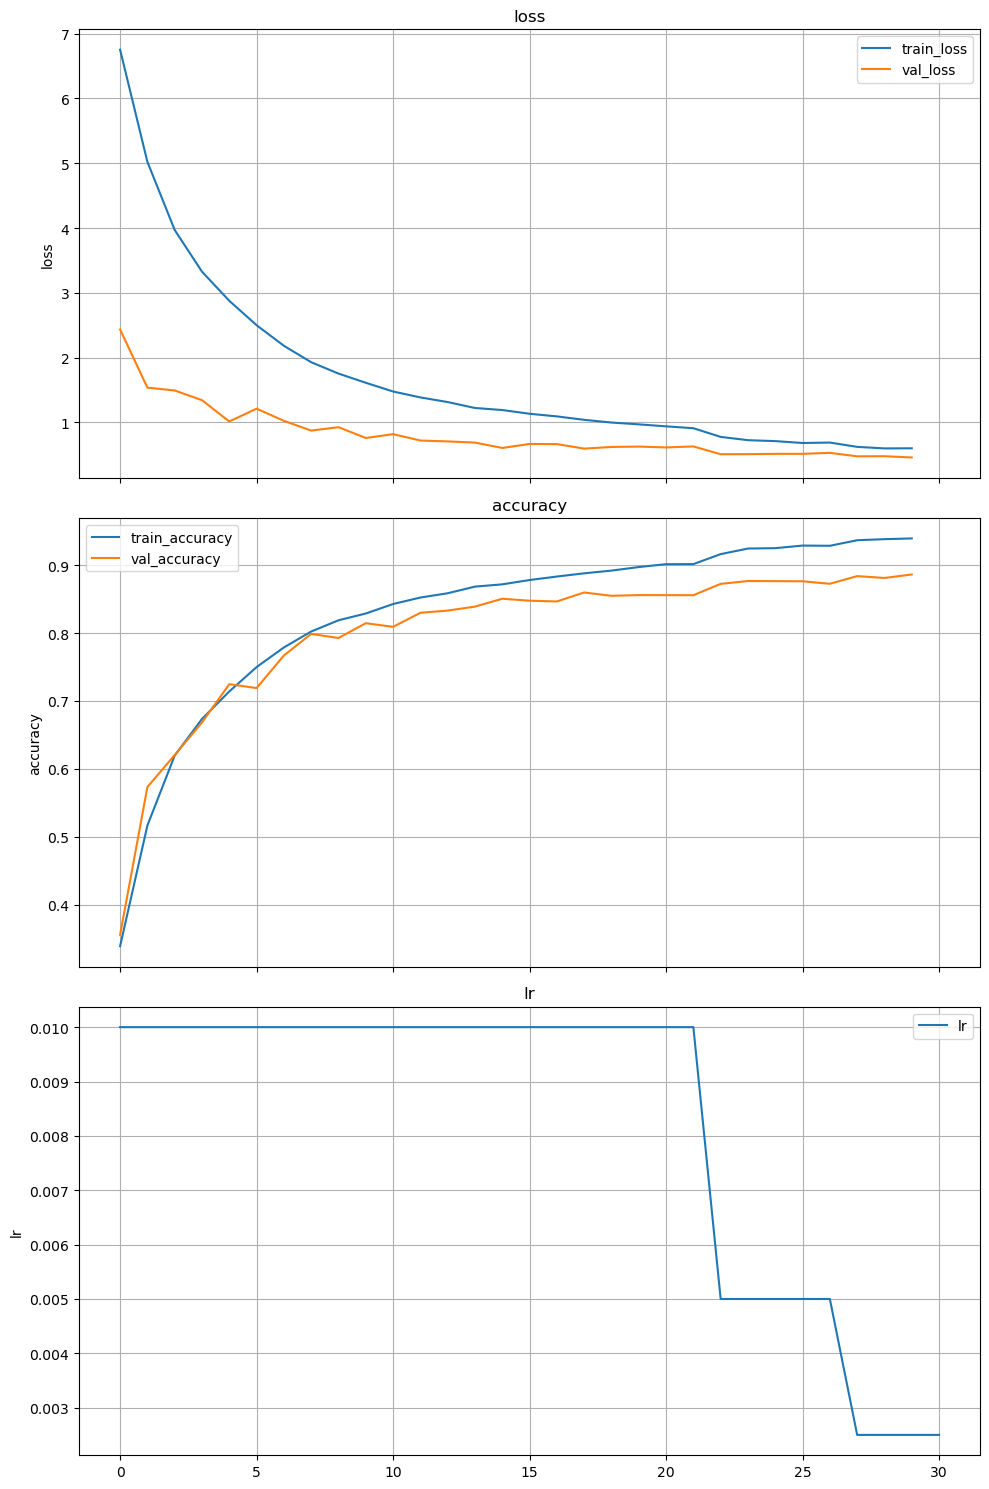

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}, ylabel='loss'>,
        <Axes: title={'center': 'accuracy'}, ylabel='accuracy'>,
        <Axes: title={'center': 'lr'}, ylabel='lr'>], dtype=object))

In [56]:
################ STUDENT AFTER LECTURES ################

soft_labels_tensor = torch.cat(soft_labels, dim = 0)
soft_labels_numpy = soft_labels_tensor.numpy()

train_dataset = DistillationDataset(cifar_train_dataset, soft_labels_numpy)
train = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = False)

temperature = 4.0
alpha = 0.7
distill_criterion = DistillationLoss(temperature = temperature, alpha = alpha)

lr = 10 * LEARNING_RATE #paper says to work with higer lr since we have more meaningful labels

res_layers_student = []
blocks_per_stage = [1, 2, 1]#2, 1]
channels = [32, 64, 128]#, 256]

for stage, (n_blocks, out_channels) in enumerate(zip(blocks_per_stage, channels)):
    for block_idx in range(n_blocks):
        stride = 2 if block_idx == 0 and stage > 0 else 1
        layer_config = {
            "out_channels": out_channels,
            "stride": stride,
            "dropout": 0.0,
            "pool": None
        }
        res_layers_student.append(layer_config)

student = ResCNN(
    input_shape = input_shape,
    res_layers = res_layers_student,
    block_type = BasicBlock,
    base_width = 64,
    norm_layer = nn.BatchNorm2d
)

output_size = student.get_output_size()
mlp_tail = MLP(
    layer_sizes = [output_size, 256, 10],
    act_funcs = [nn.ReLU, None],
    dropouts = [0.3, 0.0],
    use_bias = True
)
student.attach_mlp(mlp_tail)

optimizer = torch.optim.Adam(student.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 3)

pipeline_student = SLTrainingPipeline(
    model = student,
    criterion = distill_criterion,
    optimizer = optimizer,
    lr_scheduler = scheduler,
    metrics = metrics,
    device = device,
    run_id = 'student_after_lectures',
    log_dir = LOGS_DIR,
    checkpoint_dir = CHECKPOINTS_DIR
)

history_student = pipeline_student.fit(
    epochs = NUM_EPOCHS,
    train_loader = train,
    val_loader = val_loader,
    verbose = False
    )

pipeline_student.load()

pipeline_student.plot()

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [ ]:
# Your code here.